In [ ]:

%%capture
!git clone https://github.com/alphaameer007/RHM_FYP
!pip install torchmetrics
!pip install EMD-signal
!pip install tensorflow==2.12.0
!pip install pmdarima

In [ ]:
import pandas as pd
import numpy as np
from PyEMD import EEMD
from sklearn.feature_selection import mutual_info_regression
from scipy.fft import fft
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
import torch
import torch.nn as nn
import pylab as plt
from sklearn.preprocessing import MinMaxScaler
from PyEMD import Visualisation
from pmdarima.arima import auto_arima


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Ambil dataset dari Drive
raw = pd.read_csv("/content/drive/MyDrive/dataset/crude-oil-price_raw-data.csv")
raw = raw.iloc[::-1]
raw = raw.reset_index(drop=True)
raw.head()

,Date,Open,High,Low,Close*,Adj Close**,Volume
0,1-Sep-00,33.05,33.45,32.75,33.38,33.38,"45,869"
1,4-Sep-00,-,-,-,-,-,-
2,5-Sep-00,33.95,33.99,33.42,33.8,33.8,"55,722"
3,6-Sep-00,33.99,34.95,33.83,34.95,34.95,"74,692"
4,7-Sep-00,34.5,35.5,34.45,35.33,35.33,"74,105"


In [ ]:
# preparasi tipe data
df = raw.copy()
df = pd.DataFrame(raw)

df['Date'] = pd.to_datetime(df['Date'])
numeric_columns = ['Open', 'High', 'Low', 'Close*', 'Adj Close**']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')
df['Volume'] = pd.to_numeric(df['Volume'].str.replace(',', ''), errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5850 entries, 0 to 5849
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         5850 non-null   datetime64[ns]
 1   Open         5773 non-null   float64       
 2   High         5773 non-null   float64       
 3   Low          5773 non-null   float64       
 4   Close*       5773 non-null   float64       
 5   Adj Close**  5773 non-null   float64       
 6   Volume       5766 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 320.0 KB


In [ ]:
awal_date = '2010-01-01'
akhir_date = '2022-08-30'
df = df[(df['Date'] >= awal_date) & (df['Date'] <= akhir_date)]

In [ ]:
# Menampilkan baris yang mengandung nilai null
rows_with_null = df[df.isnull().any(axis=1)]
rows_with_null

,Date,Open,High,Low,Close*,Adj Close**,Volume
3224,2013-03-29,NaN,NaN,NaN,NaN,NaN,NaN
3931,2016-01-18,NaN,NaN,NaN,NaN,NaN,NaN
3951,2016-02-15,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# replace NaN with mean
df = df.fillna(df.mean())

<ipython-input-8-e992d53ba657>:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df = df.fillna(df.mean())


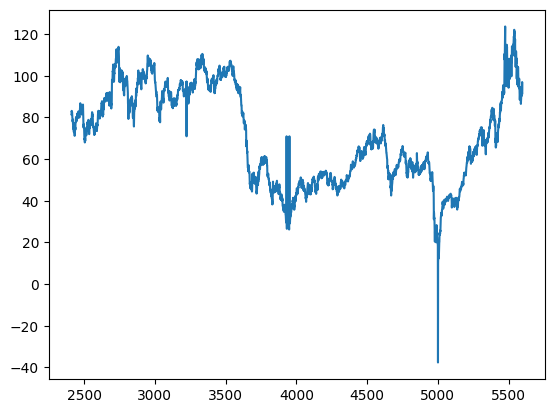

In [ ]:
# 4. Visualisasi data

plt.plot(df.index, df['Close*'])


In [ ]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [ ]:
df = df[['Date','Close*']]
df

,Date,Close*
2410,2010-01-04,81.51
2411,2010-01-05,81.77
2412,2010-01-06,83.18
2413,2010-01-07,82.66
2414,2010-01-08,82.75
...,...,...
5593,2022-08-24,94.89
5594,2022-08-25,92.52
5595,2022-08-26,93.06
5596,2022-08-29,97.01


In [ ]:
df.index = df.pop('Date')
df

,Close*
Date,
2010-01-04,81.51
2010-01-05,81.77
2010-01-06,83.18
2010-01-07,82.66
2010-01-08,82.75
...,...
2022-08-24,94.89
2022-08-25,92.52
2022-08-26,93.06


In [ ]:
t = np.array(df.index)

In [ ]:
df = pd.DataFrame(df['Close*'], index=t)
df

,Close*
2010-01-04,81.51
2010-01-05,81.77
2010-01-06,83.18
2010-01-07,82.66
2010-01-08,82.75
...,...
2022-08-24,94.89
2022-08-25,92.52
2022-08-26,93.06
2022-08-29,97.01


In [ ]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close*'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

# windowing
windowed_df = df_to_windowed_df(df,
                                '2010-01-11',
                                '2022-08-30',
                                n=5)
windowed_df

,Target Date,Target-5,Target-4,Target-3,Target-2,Target-1,Target
0,2010-01-11,81.51,81.77,83.18,82.66,82.75,82.52
1,2010-01-12,81.77,83.18,82.66,82.75,82.52,80.79
2,2010-01-13,83.18,82.66,82.75,82.52,80.79,79.65
3,2010-01-14,82.66,82.75,82.52,80.79,79.65,79.39
4,2010-01-15,82.75,82.52,80.79,79.65,79.39,78.00
...,...,...,...,...,...,...,...
3178,2022-08-24,88.11,90.50,90.77,90.23,93.74,94.89
3179,2022-08-25,90.50,90.77,90.23,93.74,94.89,92.52
3180,2022-08-26,90.77,90.23,93.74,94.89,92.52,93.06
3181,2022-08-29,90.23,93.74,94.89,92.52,93.06,97.01


In [ ]:
# Normalisasi
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def res_windowed_df_to_date_X_y_normalized(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()

    # Mengambil kolom tanggal
    dates = df_as_np[:, 0]

    # Mengambil bagian tengah matriks sebagai input (X)
    middle_matrix = df_as_np[:, 1:-1]

    # Normalisasi menggunakan MinMaxScaler
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_Y = MinMaxScaler(feature_range=(0, 1))

    X_normalized = scaler_X.fit_transform(middle_matrix.reshape(-1, 1)).reshape(middle_matrix.shape + (1,))
    Y_normalized = scaler_Y.fit_transform(df_as_np[:, -1].reshape(-1, 1)).reshape(-1,)

    return dates, X_normalized.astype(np.float32), Y_normalized.astype(np.float32), scaler_X, scaler_Y

# Memanggil fungsi dengan DataFrame yang sesuai
dates, X, y, scaler_X, scaler_Y = res_windowed_df_to_date_X_y_normalized(windowed_df)

# Mencetak bentuk (shape) dari tanggal, input (X_normalized), dan output (y_normalized)
dates.shape, X.shape, y.shape


((3183,), (3183, 5, 1), (3183,))

In [ ]:
# Fungsi untuk split data as tanggal
def split_data_by_date(dates, X, y, train_end_date, val_end_date, test_end_date):
    # Konversi string tanggal menjadi objek datetime
    dates = pd.to_datetime(dates)
    train_end_date = pd.to_datetime(train_end_date)
    val_end_date = pd.to_datetime(val_end_date)
    test_end_date = pd.to_datetime(test_end_date)

    # Membuat mask untuk memfilter data berdasarkan tanggal
    mask_train = (dates <= train_end_date)
    mask_val = (dates > train_end_date) & (dates <= val_end_date)
    mask_test = (dates > val_end_date) & (dates <= test_end_date)

    # Memisahkan data berdasarkan mask
    dates_train, X_train, y_train = dates[mask_train], X[mask_train], y[mask_train]
    dates_val, X_val, y_val = dates[mask_val], X[mask_val], y[mask_val]
    dates_test, X_test, y_test = dates[mask_test], X[mask_test], y[mask_test]

    return (dates_train, X_train, y_train), (dates_val, X_val, y_val), (dates_test, X_test, y_test)

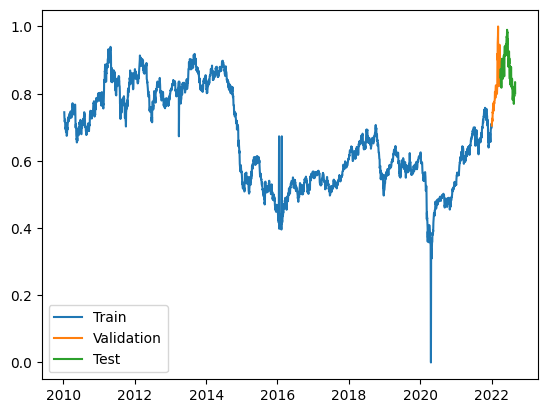

In [ ]:
# split data as tanggal case 2
train_end_date = '2021-12-31'
val_end_date = '2022-03-31'
test_end_date = '2022-08-30'

# Gunakan fungsi untuk memisahkan data
train_data, val_data, test_data = split_data_by_date(dates, X, y, train_end_date, val_end_date, test_end_date)

# Plot data
plt.plot(train_data[0], train_data[2])
plt.plot(val_data[0], val_data[2])
plt.plot(test_data[0], test_data[2])

plt.legend(['Train', 'Validation', 'Test'])
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# Fungsi untuk membuat model
def create_model(dropout_rate=0.0, units=64, optimizer='adam', activation='relu', learning_rate=0.001):
    model = Sequential([
        layers.Input((5, 1)),
        layers.LSTM(units),
        layers.Dense(32, activation=activation),
        layers.Dense(32, activation=activation),
        layers.Dense(1)
    ])

    if dropout_rate > 0.0:
        model.add(layers.Dropout(dropout_rate))

    if optimizer.lower() == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer.lower() == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(loss='mse', optimizer=optimizer, metrics=['mean_absolute_error'])

    return model

# Membuat model KerasRegressor
model = KerasRegressor(build_fn=create_model, epochs=100, batch_size=64, verbose=0)


param_grid = {
    'dropout_rate': [0.0, 0.2, 0.4],
    'units': [50, 64, 100, 150],
    'optimizer': ['adam', 'rmsprop'],
    'activation': ['relu', 'tanh'],
    'learning_rate': [0.001]
}

# Membuat objek GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=3)
grid_result = grid.fit(train_data[1], train_data[2], validation_data=(val_data[1], val_data[2]))

# Menampilkan hasil grid search
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

<ipython-input-20-1a54531254b0>:30: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, epochs=100, batch_size=64, verbose=0)


Best: -0.009339 using {'activation': 'tanh', 'dropout_rate': 0.0, 'learning_rate': 0.001, 'optimizer': 'adam', 'units': 50}


95/95 [==============================] - 2s 6ms/step


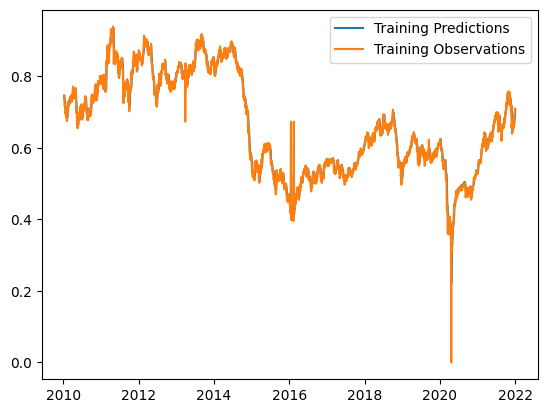

MAE (Mean Absolute Error)training: 0.008255873806774616
MSE (Mean Squared Error) training: 0.00022144340618979186


In [ ]:
# GRD SEARCH Mendapatkan model terbaik dari hasil grid search
best_model = grid_result.best_estimator_.model

# Menggunakan model terbaik untuk membuat prediksi pada data pelatihan
train_predictions = best_model.predict(train_data[1]).flatten()

# Plot hasil prediksi dan observasi untuk data pelatihan
plt.plot(train_data[0], train_predictions)
plt.plot(train_data[0], train_data[2])
plt.legend(['Training Predictions', 'Training Observations'])
plt.show()


mae = mean_absolute_error(train_data[2], train_predictions)
mse = mean_squared_error(train_data[2], train_predictions)

# Menampilkan hasil
print(f'MAE (Mean Absolute Error)training: {mae}')
print(f'MSE (Mean Squared Error) training: {mse}')

2/2 [==============================] - 0s 7ms/step


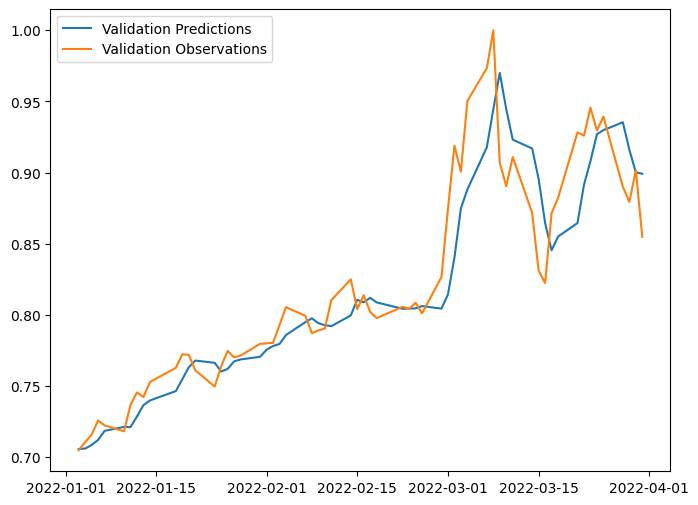

MAE (Mean Absolute Error) validasi: 0.02098340354859829
MSE (Mean Squared Error) validasi: 0.0008697534212842584


In [ ]:
# GRD SEARCH Menggunakan model terbaik untuk membuat prediksi pada data validasi
val_predictions = best_model.predict(val_data[1]).flatten()

# Plot hasil prediksi dan observasi untuk data validasi
plt.figure(figsize=(8, 6))
plt.plot(val_data[0], val_predictions)
plt.plot(val_data[0], val_data[2])
plt.legend(['Validation Predictions', 'Validation Observations'])
plt.show()

mae = mean_absolute_error(val_data[2], val_predictions)
mse = mean_squared_error(val_data[2], val_predictions)

# Menampilkan hasil
print(f'MAE (Mean Absolute Error) validasi: {mae}')
print(f'MSE (Mean Squared Error) validasi: {mse}')

4/4 [==============================] - 0s 5ms/step


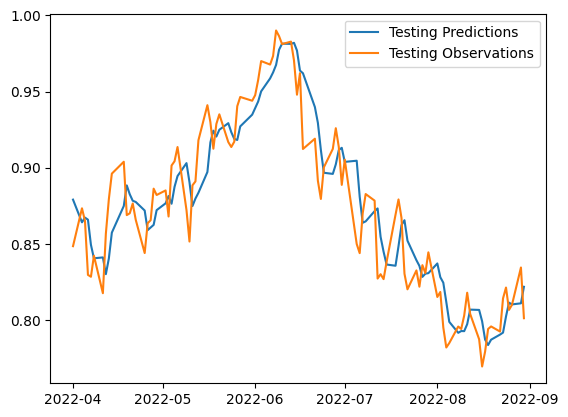

MAE (Mean Absolute Error) testing: 0.017325175926089287
MSE (Mean Squared Error) testing: 0.0004569320008158684


In [ ]:
# GRD SRCH Menggunakan model terbaik untuk membuat prediksi pada data pengujian
test_predictions = best_model.predict(test_data[1]).flatten()

# Plot hasil prediksi dan observasi untuk data pengujian
plt.plot(test_data[0], test_predictions)
plt.plot(test_data[0], test_data[2])
plt.legend(['Testing Predictions', 'Testing Observations'])
plt.show()

mae = mean_absolute_error(test_data[2], test_predictions)
mse = mean_squared_error(test_data[2], test_predictions)

# Menampilkan hasil
print(f'MAE (Mean Absolute Error) testing: {mae}')
print(f'MSE (Mean Squared Error) testing: {mse}')

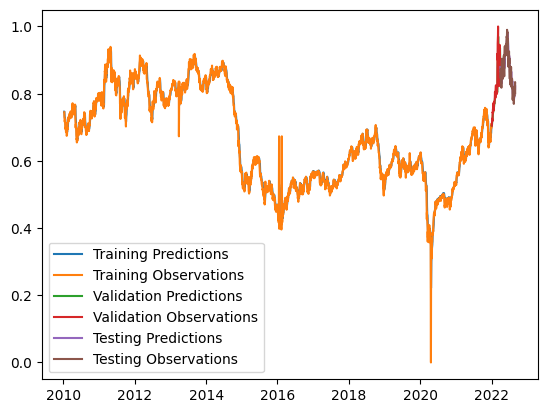

In [ ]:
# visualisasi gabungan ketiga set data
plt.plot(train_data[0], train_predictions)
plt.plot(train_data[0], train_data[2])
plt.plot(val_data[0], val_predictions)
plt.plot(val_data[0], val_data[2])
plt.plot(test_data[0], test_predictions)
plt.plot(test_data[0], test_data[2])
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

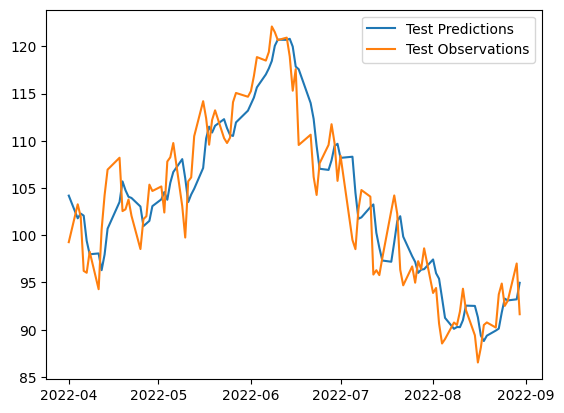

Mean Absolute Error (MAE) test: 2.7950708866119385
Mean Squared Error (MSE)test: 11.892736434936523


In [ ]:
# REVERSE TO ORIGIN SCALE
inv_test_predictions = scaler_Y.inverse_transform(test_predictions.reshape(-1, 1)).flatten()
inv_test_in = scaler_Y.inverse_transform(test_data[2].reshape(-1, 1)).flatten()

plt.plot(test_data[0],inv_test_predictions)
plt.plot(test_data[0],inv_test_in)
plt.legend(['Test Predictions', 'Test Observations'])
plt.show()

#mae mse
mae = mean_absolute_error(inv_test_in, inv_test_predictions)
mse = mean_squared_error(inv_test_in, inv_test_predictions)

print(f'Mean Absolute Error (MAE) test: {mae}')
print(f'Mean Squared Error (MSE)test: {mse}')

In [ ]:
# Menampilkan nilai MSE dari setiap iterasi
mse_values = -grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mse, stdev, param in zip(mse_values, stds, params):
    print("MSE: %f, Std: %f with: %r" % (mse, stdev, param))

result_data = {'MSE': mse_values, 'Std': stds, 'Params': params}
result_df = pd.DataFrame(result_data)
result_df.to_csv('grid_search_results.csv', index=False)

# Menampilkan pesan sukses penyimpanan
print("Results saved to 'grid_search_results.csv'")

MSE: 0.010023, Std: 0.001602 with: {'activation': 'relu', 'dropout_rate': 0.0, 'learning_rate': 0.001, 'optimizer': 'adam', 'units': 50}
MSE: 0.010070, Std: 0.000826 with: {'activation': 'relu', 'dropout_rate': 0.0, 'learning_rate': 0.001, 'optimizer': 'adam', 'units': 64}
MSE: 0.011834, Std: 0.001747 with: {'activation': 'relu', 'dropout_rate': 0.0, 'learning_rate': 0.001, 'optimizer': 'adam', 'units': 100}
MSE: 0.009807, Std: 0.001314 with: {'activation': 'relu', 'dropout_rate': 0.0, 'learning_rate': 0.001, 'optimizer': 'adam', 'units': 150}
MSE: 0.015159, Std: 0.004938 with: {'activation': 'relu', 'dropout_rate': 0.0, 'learning_rate': 0.001, 'optimizer': 'rmsprop', 'units': 50}
MSE: 0.020355, Std: 0.009510 with: {'activation': 'relu', 'dropout_rate': 0.0, 'learning_rate': 0.001, 'optimizer': 'rmsprop', 'units': 64}
MSE: 0.017709, Std: 0.000217 with: {'activation': 'relu', 'dropout_rate': 0.0, 'learning_rate': 0.001, 'optimizer': 'rmsprop', 'units': 100}
MSE: 0.013517, Std: 0.000775 

In [ ]:
# simpan hasil test
# Menampilkan close* reverse dan forecast price menggunakan test data
tabel = pd.DataFrame({
    'Date': test_data[0],
    'Close*': inv_test_in,
    'Forecast': inv_test_predictions
})

tabel

,Date,Close*,Forecast
0,2022-04-01,99.270004,104.198112
1,2022-04-04,103.280006,101.796036
2,2022-04-05,101.960007,102.295403
3,2022-04-06,96.230003,102.076729
4,2022-04-07,96.029999,99.412857
...,...,...,...
99,2022-08-24,94.890007,91.827774
100,2022-08-25,92.520004,93.290794
101,2022-08-26,93.060005,93.102844
102,2022-08-29,97.010010,93.217781


In [ ]:
tabel.to_csv('hasil_forecast_lstm.csv', index=False)

# Menampilkan pesan sukses penyimpanan
print("tabel saved to 'hasil_forecast_lstm.csv'")

tabel saved to 'hasil_forecast_lstm.csv'


# Prediksi beberapa hari kemudian

In [ ]:
start_date = test_data[0][-1]
start_date

Timestamp('2022-08-30 00:00:00')

In [ ]:
import numpy as np

# last date in test data
last_date = test_data[0][-1]

# Number of days to forecast
num_days_to_forecast = 9  # Change this to your desired number of days

# Initialize an array to store the forecasted values
forecasted_values = []

# Use the last few days from the test data to start the forecasting
input_sequence = test_data[1][-1, :, :].reshape(1, -1, 1)

# Loop to forecast for each day
for _ in range(num_days_to_forecast):
    # Make a prediction for the next day
    next_day_prediction = best_model.predict(input_sequence).flatten()[0]

    # Store the prediction in the forecasted_values array
    forecasted_values.append(next_day_prediction)

    # Update the input_sequence for the next prediction
    next_day_prediction = np.array([[next_day_prediction]])
    input_sequence = np.concatenate([input_sequence[:, 1:], np.expand_dims(next_day_prediction, axis=1)], axis=1)

def next_weekday(d):
    while d.weekday() in {5, 6}:  # 5 adalah Sabtu, 6 adalah Minggu
        d += pd.DateOffset(days=1)
    return d

forecasted_values = np.array(forecasted_values)
forecast_dates = pd.date_range(start=last_date, periods=num_days_to_forecast + 1, freq='B').map(next_weekday)[1:]

forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecast': forecasted_values
})

print(forecast_df)


1/1 [==============================] - 0s 55ms/step
        Date  Forecast
0 2022-08-31  0.821895
1 2022-09-01  0.822305
2 2022-09-02  0.822604
3 2022-09-05  0.823390
4 2022-09-06  0.824054
5 2022-09-07  0.823891
6 2022-09-08  0.824168
7 2022-09-09  0.824443
8 2022-09-12  0.824714


In [ ]:
# mengembalikan nilai prediksi ke harga
reverse_forecast =  scaler_Y.inverse_transform(forecasted_values.reshape(-1, 1)).flatten()

reverse_forecast_df = pd.DataFrame({
    'Date': forecast_df['Date'],
    'Reverse_Forecast': reverse_forecast
})

reverse_forecast_df

,Date,Reverse_Forecast
0,2022-08-31,94.966324
1,2022-09-01,95.032410
2,2022-09-02,95.080788
3,2022-09-05,95.207565
4,2022-09-06,95.314682
5,2022-09-07,95.288307
6,2022-09-08,95.333099
7,2022-09-09,95.377419
8,2022-09-12,95.421143


# PICKLE

In [ ]:
# menyimpan model keras
from tensorflow.keras.models import save_model

# Save the best model obtained from grid search
save_model(best_model, "best_model.h5")
save_model(best_model,'/content/drive/MyDrive/Tugas Besar DSAI/lstm_skenario_1/model_lstm_s1.h5')

In [ ]:
# Menyimpan model Pickle
import pickle
with open('/content/drive/MyDrive/Tugas Besar DSAI/lstm_skenario_1/model_lstm_s1.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [ ]:
# cobain panggil pickel
with open('/content/drive/MyDrive/Tugas Besar DSAI/lstm_skenario_1/model_lstm_s1.pkl', 'rb') as file:
    model_baik = pickle.load(file)
call_pikel = model_baik.predict(val_data[1]).flatten()
call_pikel

2/2 [==============================] - 1s 6ms/step


array([0.70567757, 0.70604366, 0.70850056, 0.71212226, 0.7184636 ,
       0.7212788 , 0.7210894 , 0.7285529 , 0.7365833 , 0.7398306 ,
       0.7464158 , 0.75474584, 0.76317996, 0.76788074, 0.76627976,
       0.76015025, 0.7620144 , 0.7673302 , 0.76869136, 0.77051777,
       0.7754825 , 0.77811366, 0.77952284, 0.78580785, 0.7949074 ,
       0.79758286, 0.7941211 , 0.7927775 , 0.7920352 , 0.7995823 ,
       0.81056637, 0.808827  , 0.81196886, 0.80873907, 0.8042976 ,
       0.804429  , 0.8045495 , 0.80617875, 0.8043796 , 0.8142894 ,
       0.84016246, 0.87484497, 0.8880992 , 0.9176886 , 0.94427806,
       0.97008926, 0.9445873 , 0.92314917, 0.91692954, 0.8955118 ,
       0.86459833, 0.8453929 , 0.8550223 , 0.8645376 , 0.8913993 ,
       0.90810627, 0.9269983 , 0.9298269 , 0.9353605 , 0.91611034,
       0.90018845, 0.89917594], dtype=float32)

In [ ]:
# menyimpan model Tensor

import tensorflow as tf
model_save_path = '/content/drive/MyDrive/Tugas Besar DSAI/lstm_skenario_1'
tf.saved_model.save(best_model, model_save_path)

In [ ]:
best_model.summary()

Model: "sequential_287"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_287 (LSTM)             (None, 50)                10400     
                                                                 
 dense_861 (Dense)           (None, 32)                1632      
                                                                 
 dense_862 (Dense)           (None, 32)                1056      
                                                                 
 dense_863 (Dense)           (None, 1)                 33        
                                                                 
Total params: 13,121
Trainable params: 13,121
Non-trainable params: 0
_________________________________________________________________
